## Ultrasound images classification using ResNet18

In [202]:
from PIL import Image
import os
import zipfile
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

### Data

Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

### Preprocess

I have downloaded the dataset from kaggle. Dataset was not seperated to train/test so I've created some functions in order to split it by given ratio. Also, data included mask images that I have seperated and used only ultrasound images.
Ultrasound images in the dataset were given in a different size so I resized and center-cropped it to fit to ResNet18 input size.
Dataset has different amount of images per class so I checked which class has the minimum number of images ('normal' - 133 imags) and set this number * ratio (106) to be number of images of one class of train set. total number of train set images is (106*3=318). The rest moved for test set. (it makes sense for me that train should have equal number of images per class)

In [219]:
#Extract dataset
main_path=os.getcwd()
zip_file_path = '{}/archive.zip'.format(main_path)
target_dir = '{}/dataset'.format(main_path)

In [220]:
with zipfile.ZipFile(zip_file_path) as zf:
     for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, target_dir)
        except zipfile.error as e:
            pass

Extracting : 100%|████████████████████████████████████████████████████████████████| 1578/1578 [00:03<00:00, 415.18it/s]


In [221]:
#Print dataset directory
def print_dir_hir(path):
    for dirpath, dirnames, filenames in os.walk(path):
        directory_level = dirpath.replace(path, "")
        directory_level = directory_level.count(os.sep)
        indent = " " * 4
        print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

In [222]:
dataset_path=main_path+'/dataset'
print_dir_hir(dataset_path)

dataset/
    .ipynb_checkpoints/
    Dataset_BUSI_with_GT/
        benign/
        malignant/
        normal/


In [297]:
#Few specific functions for dataset directory hierarchy
def move_files_by_str(source_dir,dest_dir,substr):
    for top, dirs, files in  os.walk(source_dir):
        for filename in files:
            if substr not in filename:
                continue
            file_path = os.path.join(top, filename)
            dest_path = os.path.join(dest_dir, filename)
            os.replace(file_path, dest_path)

def count_files_in_dir(dir_path):
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    return count

def move_files_by_percentage(source_dir, dest_dir, ratio,num_files):
    num_train_files=int(num_files*ratio)
    test_samples_cnt=0
    for top, dirs, files in os.walk(source_dir):
        for i,filename in enumerate(files):
            label = source_dir.split('//')[-1]
            if i <= num_train_files:
                file_path = os.path.join(source_dir, filename)
                train_dest_path = os.path.join(dest_dir,'Train',label, filename)
                shutil.copyfile(file_path, train_dest_path)
                #os.replace(file_path, train_dest_path)
            else:
                test_samples_cnt+=1
                file_path = os.path.join(source_dir, filename)
                train_dest_path = os.path.join(dest_dir,'Test',label, filename)
                shutil.copyfile(file_path, train_dest_path)
                #os.replace(file_path, train_dest_path)
    print(f'{num_train_files} of label {label} files copied to Train, {test_samples_cnt} to test')

def annotations_files_from_folder(root):
    annotations_file = pd.DataFrame()
    for path, subdirs, files in os.walk(root):
        for name in files:
            file_path=os.path.join(path, name)
            dest_path = os.path.join(root, name)
            if 'benign' in name:
                annotations_file=annotations_file.append([[name,0]])
            elif 'normal' in name:
                annotations_file=annotations_file.append([[name,1]])
            elif 'malignant' in name:
                annotations_file=annotations_file.append([[name,2]])
            shutil.copyfile(file_path, dest_path)
    annotations_file_path=root + '/annotations_file.csv'
    annotations_file.reset_index(drop=True, inplace=True)
    annotations_file.to_csv(annotations_file_path,index=False)
    print('annotations file created at: {}'.format(annotations_file_path))
    return annotations_file,annotations_file_path

In [235]:
#Define paths:
normal_source_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\Dataset_BUSI_with_GT//normal"
benign_source_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\Dataset_BUSI_with_GT//benign"
malignant_source_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\Dataset_BUSI_with_GT//malignant"

normal_mask_dest_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\masks//normal"
benign_mask_dest_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\masks//benign"
malignant_mask_dest_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset\masks//malignant"

dest_dir = "C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset//"

In [228]:
#Split masks from ultrasound images
substr='mask'
move_files_by_str(normal_source_dir,normal_mask_dest_dir,substr)
move_files_by_str(benign_source_dir,benign_mask_dest_dir,substr)
move_files_by_str(malignant_source_dir,malignant_mask_dest_dir,substr)

In [296]:
#Find minimum number of images per class
dirs=[normal_source_dir,benign_source_dir,malignant_source_dir]
find_min=np.inf
for dir in dirs:
    num_files=count_files_in_dir(dir)
    print(num_files)
    if num_files < find_min:
        find_min=num_files
print('minimum samples in one class: {}'.format(find_min))

133
437
210
minimum samples in one class: 133


In [237]:
#Split dataset to train and test
move_files_by_percentage(normal_source_dir,dest_dir,0.8,find_min)
move_files_by_percentage(benign_source_dir,dest_dir,0.8,find_min)
move_files_by_percentage(malignant_source_dir,dest_dir,0.8,find_min)

106 of label normal files copied to Train, 26 to test
106 of label benign files copied to Train, 330 to test
106 of label malignant files copied to Train, 103 to test


In [241]:
#Create annotations csv file for train
train_dataset_path="C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset//train"
train_annotations_file, train_annotations_file_path=annotations_files_from_folder(train_dataset_path)

#Create annotations csv file for test
test_dataset_path="C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset//test"
test_annotations_file, test_annotations_file_path=annotations_files_from_folder(test_dataset_path)

annotations file created at: C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset//train/annotations_file.csv
annotations file created at: C:\DAN\MyPortfolio\ResnetUltrasoundClassification\dataset//test/annotations_file.csv


In [294]:
#Print dataset directory after some preprocess
dataset_path=main_path+'/dataset'
print_dir_hir(dataset_path)

dataset/
    .ipynb_checkpoints/
    Dataset_BUSI_with_GT/
        benign/
        malignant/
        normal/
    masks/
        benign/
        malignant/
        normal/
    Test/
        benign/
        malignant/
        normal/
    Train/
        benign/
        malignant/
        normal/


In [414]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [404]:
#Create dataset class (I've downloaded the dataset from kaggle not from torchvision)
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)#read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [446]:
#Define transform
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Define model parameters
batch_size=20

### Model - ResNet18 pretrained

In [447]:
#Load train dataset
train_data = CustomImageDataset(train_annotations_file_path,train_dataset_path,preprocess)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True)

In [448]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=[15, 15])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


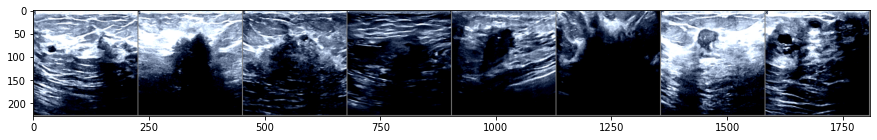

GroundTruth:  benign malignant malignant normal malignant malignant malignant benign
Shape of image is torch.Size([3, 224, 224])


In [449]:
#Show train images and their label
num_images_to_show=8
train_dataloader_to_show = DataLoader(train_data, batch_size=num_images_to_show,shuffle=True)
dataiter = iter(train_dataloader_to_show)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:num_images_to_show]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]-1]:5s}' for j in range(num_images_to_show)))
print('Shape of image is {}'.format(images[0].shape)) 

In [450]:
#Load test dataset
test_data = CustomImageDataset(test_ann_file_path,test_dataset_path,preprocess)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [451]:
#Load ResNet18
model = torchvision.models.resnet18(pretrained=True)

In [452]:
#Define optimizer, loss function and max epochs
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
max_epochs = 100

In [453]:
from tqdm import tqdm 

# initialize list of losses vs. epochs
loss_list = []
def train(model, train_loader, optimizer, criterion, max_epochs=50):
    for epoch in tqdm(range(max_epochs)):
        #  initialize average loss value
        loss_mean = 0
        # Train 1 Epoch: loop over batches
        for batch_idx, batch in enumerate(train_loader):
            # Train 1 batch
            # organize batch to samples and tragets
            samples, targets = batch
            # zero the optimizer gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(samples)
            # Calculate loss
            loss=criterion(outputs, targets)
            # Back-propagation
            loss.backward()
            # optimizer step
            optimizer.step()
            # aggregate loss
            loss_mean += loss.item()
        # Normalize loss
        loss_mean /= (batch_idx + 1)
        print('Loss: {}, Epoch: {}'.format(loss_mean, epoch))
        # Add loss to list
        loss_list.append(loss_mean)
    return loss_list
loss_list = train(model,train_dataloader,optimizer,criterion,max_epochs)

  1%|▊                                                                                 | 1/100 [00:33<56:02, 33.97s/it]

Loss: 3.6143657705363106, Epoch: 0


  2%|█▌                                                                              | 2/100 [01:13<1:01:04, 37.40s/it]

Loss: 0.25610449943034086, Epoch: 1


  3%|██▍                                                                             | 3/100 [01:51<1:00:32, 37.45s/it]

Loss: 0.2377199765863171, Epoch: 2


  4%|███▎                                                                              | 4/100 [02:28<59:31, 37.20s/it]

Loss: 0.10731153532533962, Epoch: 3


  5%|████                                                                              | 5/100 [03:06<59:27, 37.55s/it]

Loss: 0.06383048362947781, Epoch: 4


  6%|████▉                                                                             | 6/100 [03:43<58:54, 37.60s/it]

Loss: 0.2117278612088686, Epoch: 5


  7%|█████▋                                                                            | 7/100 [04:21<58:18, 37.61s/it]

Loss: 0.15062549098750905, Epoch: 6


  8%|██████▌                                                                           | 8/100 [04:58<57:30, 37.50s/it]

Loss: 0.15380547066246542, Epoch: 7


  9%|███████▍                                                                          | 9/100 [05:37<57:14, 37.74s/it]

Loss: 0.15735258339041405, Epoch: 8


 10%|████████                                                                         | 10/100 [06:14<56:18, 37.54s/it]

Loss: 0.06683433609192863, Epoch: 9


 11%|████████▉                                                                        | 11/100 [06:52<55:52, 37.67s/it]

Loss: 0.056306089130778086, Epoch: 10


 12%|█████████▋                                                                       | 12/100 [07:31<55:53, 38.11s/it]

Loss: 0.10858071148943375, Epoch: 11


 13%|██████████▌                                                                      | 13/100 [08:08<55:02, 37.96s/it]

Loss: 0.061118572601117194, Epoch: 12


 14%|███████████▎                                                                     | 14/100 [08:46<54:24, 37.96s/it]

Loss: 0.17823880467810393, Epoch: 13


 15%|████████████▏                                                                    | 15/100 [09:23<53:16, 37.61s/it]

Loss: 0.08504187583628878, Epoch: 14


 16%|████████████▉                                                                    | 16/100 [10:00<52:25, 37.45s/it]

Loss: 0.03208386427414713, Epoch: 15


 17%|█████████████▊                                                                   | 17/100 [10:38<51:50, 37.48s/it]

Loss: 0.11225937521222103, Epoch: 16


 18%|██████████████▌                                                                  | 18/100 [11:15<51:09, 37.43s/it]

Loss: 0.033476658394861525, Epoch: 17


 19%|███████████████▍                                                                 | 19/100 [11:53<50:44, 37.59s/it]

Loss: 0.10099720347994555, Epoch: 18


 20%|████████████████▏                                                                | 20/100 [12:30<49:58, 37.48s/it]

Loss: 0.10184981812284712, Epoch: 19


 21%|█████████████████                                                                | 21/100 [13:08<49:20, 37.47s/it]

Loss: 0.11929292552282705, Epoch: 20


 22%|█████████████████▊                                                               | 22/100 [13:45<48:40, 37.44s/it]

Loss: 0.07716267922317938, Epoch: 21


 23%|██████████████████▋                                                              | 23/100 [14:22<47:52, 37.30s/it]

Loss: 0.015194787589066169, Epoch: 22


 24%|███████████████████▍                                                             | 24/100 [14:59<47:16, 37.32s/it]

Loss: 0.0814074003839564, Epoch: 23


 25%|████████████████████▎                                                            | 25/100 [15:37<46:41, 37.35s/it]

Loss: 0.042334016749758605, Epoch: 24


 26%|█████████████████████                                                            | 26/100 [16:14<46:02, 37.33s/it]

Loss: 0.12135470175074742, Epoch: 25


 27%|█████████████████████▊                                                           | 27/100 [16:52<45:25, 37.34s/it]

Loss: 0.02439864697996253, Epoch: 26


 28%|██████████████████████▋                                                          | 28/100 [17:29<44:41, 37.24s/it]

Loss: 0.028815788232296816, Epoch: 27


 29%|███████████████████████▍                                                         | 29/100 [18:06<44:13, 37.37s/it]

Loss: 0.04279604204587967, Epoch: 28


 30%|████████████████████████▎                                                        | 30/100 [18:44<43:35, 37.36s/it]

Loss: 0.05026748089585453, Epoch: 29


 31%|█████████████████████████                                                        | 31/100 [19:20<42:49, 37.23s/it]

Loss: 0.2546566479491851, Epoch: 30


 32%|█████████████████████████▉                                                       | 32/100 [19:58<42:17, 37.31s/it]

Loss: 0.11851358399315573, Epoch: 31


 33%|██████████████████████████▋                                                      | 33/100 [20:35<41:42, 37.35s/it]

Loss: 0.13020807440283105, Epoch: 32


 34%|███████████████████████████▌                                                     | 34/100 [21:13<41:07, 37.39s/it]

Loss: 0.10506079412366756, Epoch: 33


 35%|████████████████████████████▎                                                    | 35/100 [21:51<40:51, 37.72s/it]

Loss: 0.05763525518533938, Epoch: 34


 36%|█████████████████████████████▏                                                   | 36/100 [22:29<40:09, 37.65s/it]

Loss: 0.057561586488565596, Epoch: 35


 37%|█████████████████████████████▉                                                   | 37/100 [23:06<39:30, 37.62s/it]

Loss: 0.05160485700060449, Epoch: 36


 38%|██████████████████████████████▊                                                  | 38/100 [23:44<38:58, 37.72s/it]

Loss: 0.035483757403733975, Epoch: 37


 39%|███████████████████████████████▌                                                 | 39/100 [24:21<38:08, 37.51s/it]

Loss: 0.028292269208845134, Epoch: 38


 40%|████████████████████████████████▍                                                | 40/100 [24:59<37:33, 37.55s/it]

Loss: 0.005933169599088347, Epoch: 39


 41%|█████████████████████████████████▏                                               | 41/100 [25:37<37:10, 37.80s/it]

Loss: 0.010399323809371494, Epoch: 40


 42%|██████████████████████████████████                                               | 42/100 [26:16<36:45, 38.03s/it]

Loss: 0.14850271111337113, Epoch: 41


 43%|██████████████████████████████████▊                                              | 43/100 [26:55<36:25, 38.34s/it]

Loss: 0.19332357587785842, Epoch: 42


 44%|███████████████████████████████████▋                                             | 44/100 [27:32<35:25, 37.95s/it]

Loss: 0.16382173749940088, Epoch: 43


 45%|████████████████████████████████████▍                                            | 45/100 [28:10<34:41, 37.85s/it]

Loss: 0.15973866249859223, Epoch: 44


 46%|█████████████████████████████████████▎                                           | 46/100 [28:48<34:02, 37.83s/it]

Loss: 0.06877009964527507, Epoch: 45


 47%|██████████████████████████████████████                                           | 47/100 [29:25<33:21, 37.76s/it]

Loss: 0.11177865626386312, Epoch: 46


 48%|██████████████████████████████████████▉                                          | 48/100 [30:02<32:36, 37.63s/it]

Loss: 0.06918001960002584, Epoch: 47


 49%|███████████████████████████████████████▋                                         | 49/100 [30:40<31:59, 37.63s/it]

Loss: 0.07048653145081035, Epoch: 48


 50%|████████████████████████████████████████▌                                        | 50/100 [31:20<31:50, 38.22s/it]

Loss: 0.05824765218387577, Epoch: 49


 51%|█████████████████████████████████████████▎                                       | 51/100 [31:58<31:19, 38.36s/it]

Loss: 0.04547327420090476, Epoch: 50


 52%|██████████████████████████████████████████                                       | 52/100 [32:38<30:59, 38.73s/it]

Loss: 0.1328712136566858, Epoch: 51


 53%|██████████████████████████████████████████▉                                      | 53/100 [33:15<30:01, 38.33s/it]

Loss: 0.12882622624473536, Epoch: 52


 54%|███████████████████████████████████████████▋                                     | 54/100 [33:53<29:19, 38.24s/it]

Loss: 0.22184220263871418, Epoch: 53


 55%|████████████████████████████████████████████▌                                    | 55/100 [34:30<28:22, 37.84s/it]

Loss: 0.10728043025386903, Epoch: 54


 56%|█████████████████████████████████████████████▎                                   | 56/100 [35:07<27:36, 37.64s/it]

Loss: 0.06358779071802821, Epoch: 55


 57%|██████████████████████████████████████████████▏                                  | 57/100 [35:45<27:00, 37.68s/it]

Loss: 0.10147163437282228, Epoch: 56


 58%|██████████████████████████████████████████████▉                                  | 58/100 [36:23<26:19, 37.62s/it]

Loss: 0.1276552099666065, Epoch: 57


 59%|███████████████████████████████████████████████▊                                 | 59/100 [37:00<25:37, 37.51s/it]

Loss: 0.10836956466236562, Epoch: 58


 60%|████████████████████████████████████████████████▌                                | 60/100 [37:37<24:59, 37.48s/it]

Loss: 0.07882718199235729, Epoch: 59


 61%|█████████████████████████████████████████████████▍                               | 61/100 [38:15<24:20, 37.44s/it]

Loss: 0.07673773523535654, Epoch: 60


 62%|██████████████████████████████████████████████████▏                              | 62/100 [38:53<23:49, 37.61s/it]

Loss: 0.07465992120106581, Epoch: 61


 63%|███████████████████████████████████████████████████                              | 63/100 [39:30<23:04, 37.41s/it]

Loss: 0.014728795642012675, Epoch: 62


 64%|███████████████████████████████████████████████████▊                             | 64/100 [40:07<22:23, 37.32s/it]

Loss: 0.07304238596171832, Epoch: 63


 65%|████████████████████████████████████████████████████▋                            | 65/100 [40:44<21:49, 37.40s/it]

Loss: 0.08739649756085675, Epoch: 64


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [41:22<21:17, 37.59s/it]

Loss: 0.05329337121014867, Epoch: 65


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [41:59<20:35, 37.44s/it]

Loss: 0.06352672027423978, Epoch: 66


 68%|███████████████████████████████████████████████████████                          | 68/100 [42:39<20:19, 38.11s/it]

Loss: 0.11332398677854251, Epoch: 67


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [43:17<19:37, 37.97s/it]

Loss: 0.027169364660307217, Epoch: 68


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [43:58<19:29, 39.00s/it]

Loss: 0.026145375278942725, Epoch: 69


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [44:36<18:43, 38.76s/it]

Loss: 0.1624598423633656, Epoch: 70


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [45:14<17:56, 38.46s/it]

Loss: 0.0543928910196615, Epoch: 71


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [45:52<17:15, 38.33s/it]

Loss: 0.03359564293564558, Epoch: 72


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [46:29<16:27, 37.98s/it]

Loss: 0.12088689974317436, Epoch: 73


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [47:07<15:44, 37.79s/it]

Loss: 0.03826991155994405, Epoch: 74


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [47:44<15:03, 37.63s/it]

Loss: 0.07649166669965352, Epoch: 75


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [48:22<14:28, 37.75s/it]

Loss: 0.02283924199967741, Epoch: 76


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [49:00<13:50, 37.74s/it]

Loss: 0.031118028657254077, Epoch: 77


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [49:37<13:08, 37.55s/it]

Loss: 0.07852173716245862, Epoch: 78


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [50:15<12:33, 37.68s/it]

Loss: 0.04898204899697756, Epoch: 79


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [50:52<11:55, 37.65s/it]

Loss: 0.08495608805370626, Epoch: 80


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [51:31<11:23, 37.98s/it]

Loss: 0.0475440419943291, Epoch: 81


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [52:09<10:46, 38.02s/it]

Loss: 0.023441562747500616, Epoch: 82


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [52:47<10:04, 37.80s/it]

Loss: 0.02491369703270988, Epoch: 83


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [53:24<09:24, 37.64s/it]

Loss: 0.007308605359867215, Epoch: 84


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [54:02<08:48, 37.74s/it]

Loss: 0.03332743534958675, Epoch: 85


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [54:39<08:08, 37.57s/it]

Loss: 0.017093926897573778, Epoch: 86


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [55:17<07:31, 37.66s/it]

Loss: 0.018293398617328527, Epoch: 87


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [55:54<06:52, 37.54s/it]

Loss: 0.0025481066400329035, Epoch: 88


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [56:33<06:18, 37.84s/it]

Loss: 0.00390699189301813, Epoch: 89


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [57:11<05:40, 37.89s/it]

Loss: 0.0318881236588127, Epoch: 90


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [57:48<05:00, 37.60s/it]

Loss: 0.010482873696994776, Epoch: 91


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [58:27<04:27, 38.19s/it]

Loss: 0.04399324012357444, Epoch: 92


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [59:05<03:47, 37.97s/it]

Loss: 0.03200552239660978, Epoch: 93


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [59:42<03:08, 37.77s/it]

Loss: 0.021155418629752926, Epoch: 94


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:00:19<02:30, 37.65s/it]

Loss: 0.013449525592103087, Epoch: 95


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:00:57<01:53, 37.80s/it]

Loss: 0.0797521851658102, Epoch: 96


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:01:34<01:15, 37.55s/it]

Loss: 0.005082893604755073, Epoch: 97


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:02:13<00:37, 37.73s/it]

Loss: 0.005463539808474974, Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:51<00:00, 37.71s/it]

Loss: 0.003188394149594173, Epoch: 99


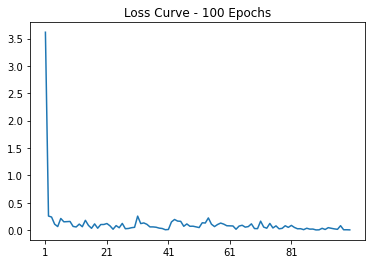

In [454]:
import matplotlib.pyplot as plt
import math
def plot_loss(loss_list):
    epochs_axis=np.arange(len(loss_list))+1
    xticks = range(math.floor(min(epochs_axis)), math.ceil(max(epochs_axis))+1,int(len(loss_list)/5))
    plt.figure()
    plt.plot(epochs_axis,loss_list)
    plt.title('Loss Curve - {} Epochs'.format(len(epochs_axis)))
    plt.xticks(xticks)
    plt.show()

plot_loss(loss_list)

In [455]:
PATH = './dudi_resnet18_50ep_3e4lr.pth'
torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [456]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [457]:
classes = ('benign', 'normal', 'malignant')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


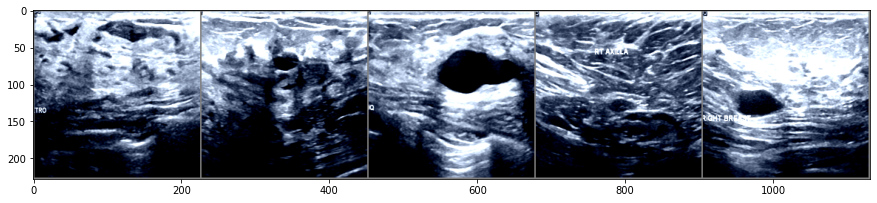

GroundTruth:  benign benign benign benign benign


In [458]:
#Show test images and their label
num_images_to_show=5
imshow(torchvision.utils.make_grid(images[0:num_images_to_show]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]-1]:5s}' for j in range(num_images_to_show)))

In [459]:
outputs = model(images)

In [460]:
#Print test images predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]-1]:5s}'
                              for j in range(num_images_to_show)))

Predicted:  normal benign benign malignant benign


In [461]:
#Accuracy of total test images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 41 %


In [462]:
#Accuracy of test images by class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label-1]] += 1
            total_pred[classes[label-1]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: benign is 35.5 %
Accuracy for class: normal is 69.2 %
Accuracy for class: malignant is 53.4 %


<AxesSubplot:>

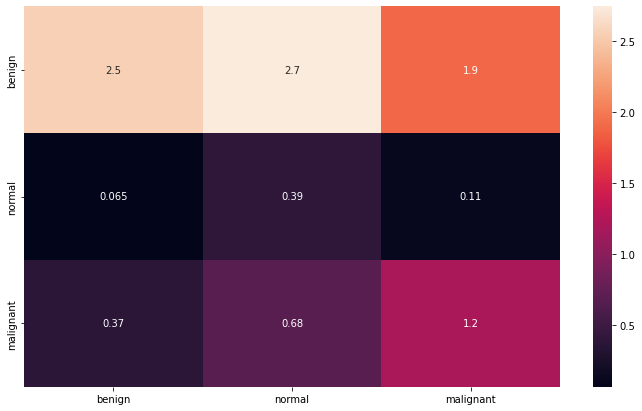

In [464]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        



# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

Intermediate Summary:
Net results are not good enough, it seems from confusion matrix that model is biased to classify to benign label. Here are some possible issues and solutions.

| Possible issue | Possible solution |
| --- | --- |
| Lack of data | Download more data. Change train to test ratio and check again. |
| --- | --- |
| Transform Parameters | Change Resize method. Change normalize value (mean,std.) |
| --- | --- |
| Hyper Parameters | Change learning rate, batch size, loss function, optimizer. |
| --- | --- |
| Classes similarity | Train and test the model for normal and malignant (best and worst case). Without benign (middle case). |











